In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cv2
import random

In [2]:
tumor = ("data/brain_tumor_dataset/updated_yes/*")
no_tumor = ("data/brain_tumor_dataset/updated_no/*")



This dataset is imbalanced

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2025-09-14 22:34:53.863340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create Data Augmentation
This helps with imblanced data

In [4]:
def aug_data(folder, samples, save_folder):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3,1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )


    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = img.reshape((1,) + img.shape)  # shape (1, h, w, c)
        save = 'aug_' + filename[:-4] 

        count = 0
        for batch in datagen.flow(
            img,
            batch_size=1,
            save_to_dir=save_folder,
            save_prefix='aug',
            save_format='jpeg'
        ):
            count += 1
            if count >= samples:  
                break
 

In [5]:
yes_folder = "../data/brain_tumor_dataset/updated_yes"
no_folder  = "../data/brain_tumor_dataset/updated_no"
aug_data_folder = "../aug_data"

aug_data(folder=yes_folder, samples=6, save_folder=aug_data_folder+"/yes")
aug_data(folder=no_folder,  samples=9, save_folder=aug_data_folder+"/no")


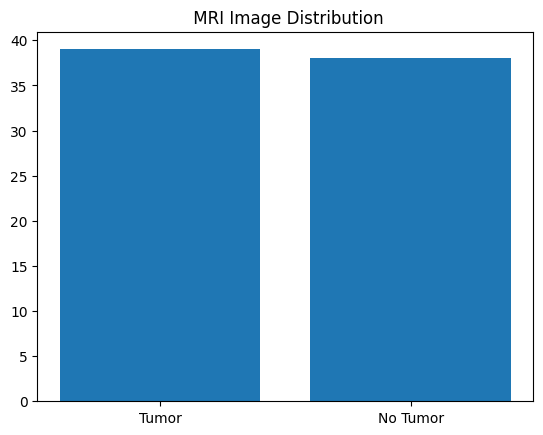

In [6]:

counts = [len(yes_folder), len(no_folder)]
labels = ["Tumor", "No Tumor"]

# Plot
plt.bar(labels, counts)
plt.title(" MRI Image Distribution")
plt.show()

In [7]:
yes_folder = "../aug_data/yes"
no_folder  = "../aug_data/no"

num_yes = len([f for f in os.listdir(yes_folder) if f.lower().endswith(('.jpeg'))])
num_no  = len([f for f in os.listdir(no_folder) if f.lower().endswith(('.jpeg'))])

print("Number of yes tumor images:", num_yes)
print("Number of no tumor images:", num_no)
print("Total images:", num_yes + num_no)


Number of yes tumor images: 894
Number of no tumor images: 838
Total images: 1732


## Pre-Processing

In [8]:
import imutils
def crop_center(imgages, pixels=False):
    cropped_images = []
    for img in imgages:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Thresholding to create a binary image
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours
        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)
        c = max(contours, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        cropped_images.append(new_img)
    return cropped_images

In [9]:
def crop_center(images, pixels=False):
    cropped_images = []
    debug_data = []  
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)
        c = max(contours, key=cv2.contourArea)

        # extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, 
                      extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        cropped_images.append(new_img)
        debug_data.append((img_cnt, img_pnt, new_img))

    return cropped_images, debug_data


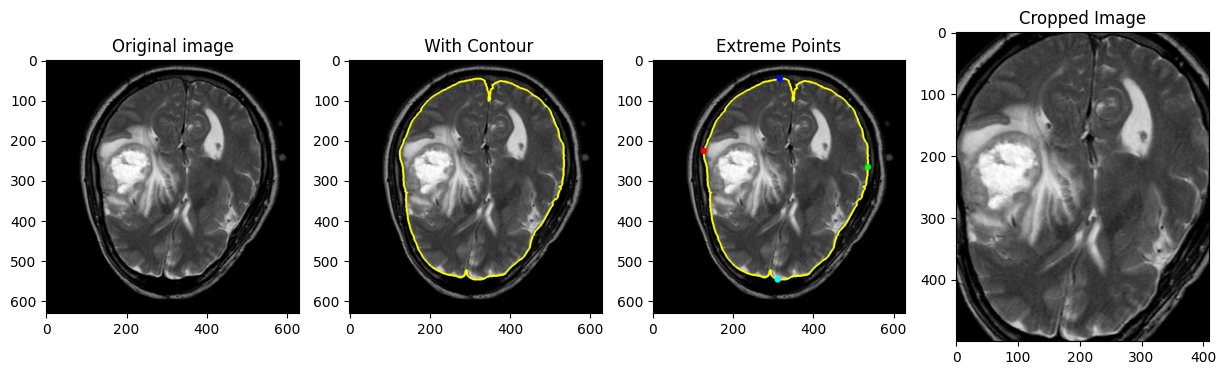

In [13]:


img = cv2.imread("../aug_data/yes/aug_0_119.jpeg")
cropped, debug = crop_center([img])  
img_cnt, img_pnt, new_img = debug[0] 

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original image')

plt.subplot(142)
plt.imshow(cv2.cvtColor(img_cnt, cv2.COLOR_BGR2RGB))
plt.title(' With Contour')

plt.subplot(143)
plt.imshow(cv2.cvtColor(img_pnt, cv2.COLOR_BGR2RGB))
plt.title('Extreme Points')

plt.subplot(144)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image')
plt.show()

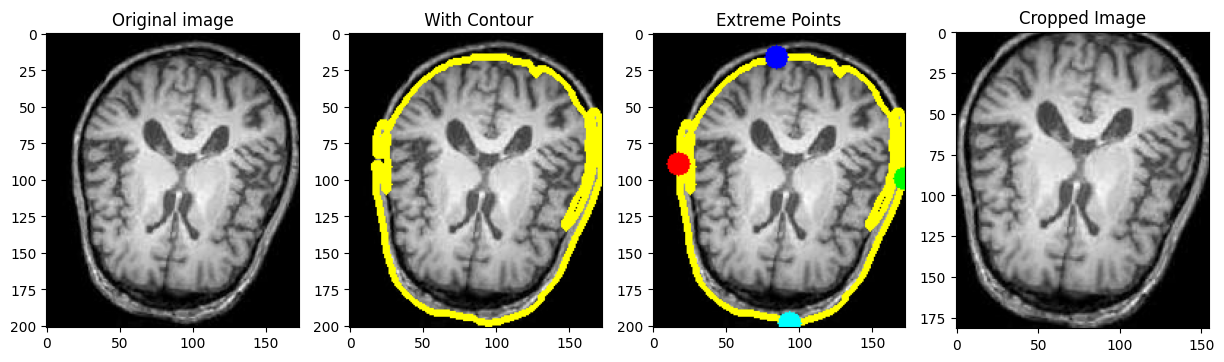

In [14]:
img = cv2.imread("../aug_data/no/aug_0_60.jpeg")
cropped, debug = crop_center([img])  
img_cnt, img_pnt, new_img = debug[0] 

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original image')

plt.subplot(142)
plt.imshow(cv2.cvtColor(img_cnt, cv2.COLOR_BGR2RGB))
plt.title(' With Contour')

plt.subplot(143)
plt.imshow(cv2.cvtColor(img_pnt, cv2.COLOR_BGR2RGB))
plt.title('Extreme Points')

plt.subplot(144)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image')
plt.show()

## Apply this method to all the images

In [11]:
from sklearn.utils import shuffle

In [10]:
def load_data(folders, img_size=(224, 224)):
    x = []
    y = []

    for folder in folders:
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)

            if img is None:
                continue  # skip unreadable files

            # Apply crop_center
            cropped_list, _ = crop_center([img])
            if len(cropped_list) == 0:
                continue  # skip if crop fails
            img = cropped_list[0]

            # Resize + normalize
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
            img = img / 255.0
            x.append(img)

            # Assign labels
            if folder.endswith('yes'):
                y.append(1)
            else:
                y.append(0)

    x = np.array(x)
    y = np.array(y)
    x, y = shuffle(x, y)

    print("Loaded images:", x.shape)
    print("Labels:", y.shape)

    return x, y



In [14]:
# Apply cropping to all images and save them
folder1 = "../aug_data/yes"
folder2 = "../aug_data/no"

for folder in [folder1, folder2]:
    images = []
    file_names = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpeg')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                file_names.append(filename)

    cropped_images, _ = crop_center(images)

    for i, cropped_img in enumerate(cropped_images):
        save_path = os.path.join(folder, file_names[i])
        cv2.imwrite(save_path, cropped_img)

In [16]:

from sklearn.utils import shuffle



agu_data_folder = "../aug_data/"
yes_folder = agu_data_folder + "yes"
no_folder = agu_data_folder + "no"

# Load augmented data
x,y = load_data([yes_folder, no_folder], img_size=(224, 224))


Loaded images: (1732, 224, 224, 3)
Labels: (1732,)


In [15]:
# plot some random images

def plot_images(x,y,labels_dict, n=50):
    for index in range(len(labels_dict)):
        img = x[np.argwhere(y==index)]
        num_img = img[:n]

        col_num = 10
        row_num = int(n/col_num)
        plt.figure(figsize=(15,7))

        i = 1
        for image in num_img:
            plt.subplot(row_num, col_num, i)
            plt.imshow(image[0])

            plt.xticks([])
            plt.yticks([])
            i += 1
        plt.suptitle('Brain Tumor: {}'.format(labels_dict[index]))
        plt.show()
        


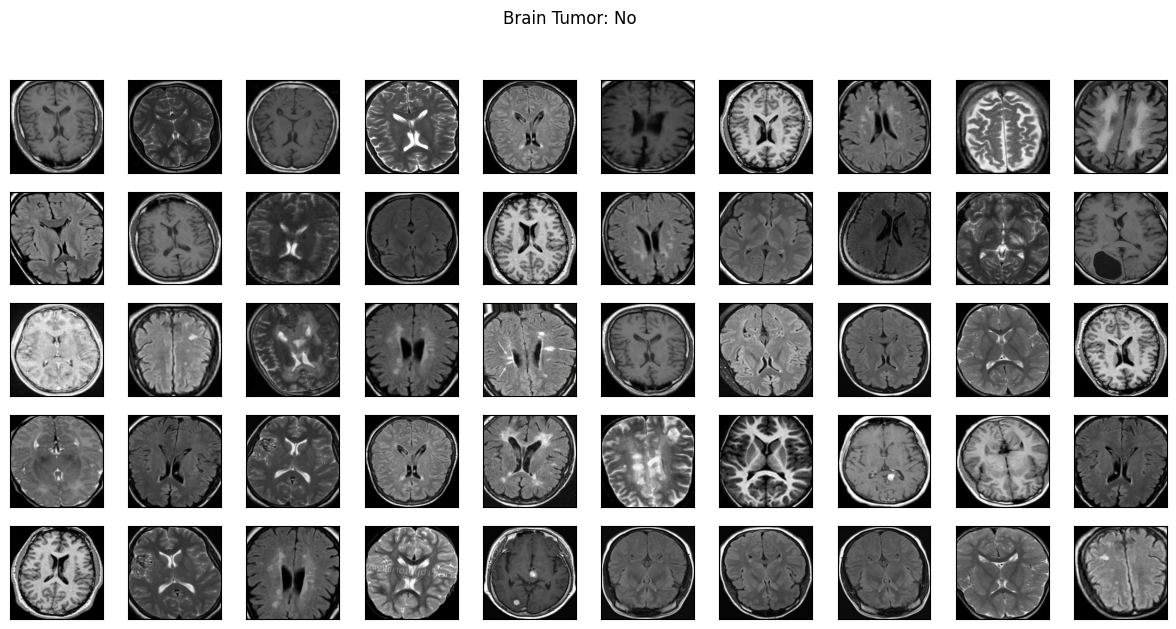

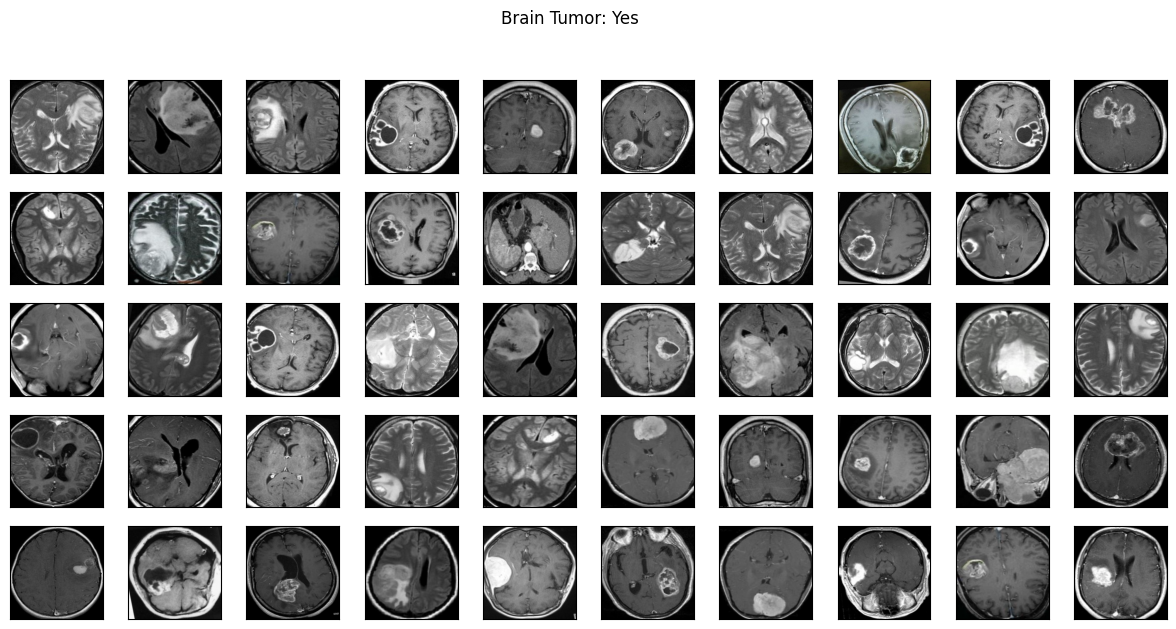

In [16]:
plot_images(x, y, labels_dict={0: 'No', 1: 'Yes'}, n=50)


## Split the data
Spliting between 80% train, 10% testing and 10% vaildtion 


In [17]:
# create the folders
if not os.path.isdir('split_data'):
    new_dir = 'split_data'
    os.mkdir(new_dir)


In [18]:
if not os.path.isdir('split_data/train'):
    train = os.path.join(new_dir, 'train')
    os.mkdir(train)

if not os.path.isdir('split_data/validation'):
    val = os.path.join(new_dir, 'validation')
    os.mkdir(val)

if not os.path.isdir('split_data/test'):
    test = os.path.join(new_dir, 'test')
    os.mkdir(test)

In [19]:
if not os.path.isdir('split_data/train/yes'):
    train_yes = os.path.join(train, 'yes')
    os.mkdir(train_yes)

if not os.path.isdir('split_data/train/no'):
    train_no = os.path.join(train, 'no')
    os.mkdir(train_no)

if not os.path.isdir('split_data/validation/yes'):  
    val_yes = os.path.join(val, 'yes')
    os.mkdir(val_yes)
if not os.path.isdir('split_data/validation/no'):
    val_no = os.path.join(val, 'no')
    os.mkdir(val_no)
if not os.path.isdir('split_data/test/yes'):
    test_yes = os.path.join(test, 'yes')
    os.mkdir(test_yes)
if not os.path.isdir('split_data/test/no'):
    test_no = os.path.join(test, 'no')
    os.mkdir(test_no)

In [20]:
aug_yes = os.path.join("../aug_data/yes/")
aug_no  = os.path.join("../aug_data/no/")

In [21]:
# create the  yes train
import shutil
file = os.listdir("../aug_data/yes")
fname = []
train_count = int(0.8 * len(file))
for i in range(train_count):
    fname.append(file[i])
for fname in fname:
    src = os.path.join(aug_yes, fname) 
    dst = os.path.join(train_yes, fname) 
    shutil.copyfile(src, dst)

In [22]:
# create the yes test
file = os.listdir("../aug_data/yes")

test_count = int(0.1 * len(file))  # 10%
fname = file[:test_count]  # first 10% for test

for f in fname:
    src = os.path.join(aug_yes, f)
    dst = os.path.join(test_yes, f)  
    shutil.copyfile(src, dst)


In [23]:
# create the yes val
file = os.listdir("../aug_data/yes")
val_count = int(0.1 * len(file))  # 10% for validation
fname = file[:val_count]  # first 10% for val

for f in fname:
    src = os.path.join(aug_yes, f)
    dst = os.path.join(val_yes, f)   
    shutil.copyfile(src, dst)

In [24]:
# ctreate the no train
file = os.listdir("../aug_data/no")
fname = []
train_count = int(0.8 * len(file))
for i in range(train_count):
    fname.append(file[i])
for fname in fname:
    src = os.path.join(aug_no, fname) 
    dst = os.path.join(train_no, fname) 
    shutil.copyfile(src, dst)

In [25]:
# create the no test
file = os.listdir("../aug_data/no")
test_count = int(0.1 * len(file))  # 10%
fname = file[:test_count]  # first 10% for test
for f in fname:
    src = os.path.join(aug_no, f)
    dst = os.path.join(test_no, f)  
    shutil.copyfile(src, dst)

In [26]:
# create the no val
file = os.listdir("../aug_data/no")
val_count = int(0.1 * len(file))  # 10% for validation
fname = file[:val_count]  # first 10% for val
for f in fname:
    src = os.path.join(aug_no, f)
    dst = os.path.join(val_no, f)   
    shutil.copyfile(src, dst)


In [27]:
import plotly.graph_objs as go
from plotly.offline import iplot

train_yes = "split_data/train/yes"
train_no  = "split_data/train/no"
val_yes   = "split_data/validation/yes"
val_no    = "split_data/validation/no"
test_yes  = "split_data/test/yes"
test_no   = "split_data/test/no"

# Count images in each folder
train_counts = [len(os.listdir(train_no)), len(os.listdir(train_yes))]
val_counts   = [len(os.listdir(val_no)), len(os.listdir(val_yes))]
test_counts  = [len(os.listdir(test_no)), len(os.listdir(test_yes))]

# Build dict for easy graphing
y = dict()
y[0] = [train_counts[0], val_counts[0], test_counts[0]]  # No (0)
y[1] = [train_counts[1], val_counts[1], test_counts[1]]  # Yes (1)

# Plot
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='yellow'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='green'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




## Modeling

In [28]:
img_size = (224, 224)
batch_size = 32

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest'
                                  )
train_generator = train_datagen.flow_from_directory('split_data/train/', 
                                  target_size=img_size, batch_size=batch_size, 
                                  class_mode='categorical', shuffle=True, seed=42, color_mode='rgb') 


Found 1385 images belonging to 2 classes.


In [30]:
test_datagen  = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('split_data/test/', 
                                  target_size=img_size, batch_size=batch_size, 
                                  class_mode='categorical', shuffle=False, color_mode='rgb')

Found 172 images belonging to 2 classes.


In [32]:
val_datagen   = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory('split_data/validation/', 
                                  target_size=img_size, batch_size=batch_size, 
                                  class_mode='categorical', shuffle=False, color_mode='rgb')

Found 172 images belonging to 2 classes.


In [33]:
class_labels = (train_generator.class_indices)
class_labels = {v: k for k, v in class_labels.items()}
print(class_labels)

{0: 'no', 1: 'yes'}


## Model 1: CNN 

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(224, 224, 3)),   
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(224, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(224, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")   
])


In [35]:
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)


Model input shape: (None, 224, 224, 3)
Model output shape: (None, 2)


In [37]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.5395 - loss: 0.7248 - val_accuracy: 0.5437 - val_loss: 0.6757
Epoch 2/40
 1/43 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.5312 - loss: 0.7054

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5312 - loss: 0.7054 - val_accuracy: 0.5063 - val_loss: 0.6800
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.6305 - loss: 0.6472 - val_accuracy: 0.8062 - val_loss: 0.5189
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8438 - loss: 0.5277 - val_accuracy: 0.7937 - val_loss: 0.5208
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.6778 - loss: 0.6018 - val_accuracy: 0.7437 - val_loss: 0.5262
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7188 - loss: 0.6383 - val_accuracy: 0.7688 - val_loss: 0.5301
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.7066 - loss: 0.5793 - val_accuracy: 0.8375 - val_loss: 0.4002
Epoch 8/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6875 - loss: 0.5357 - val_accuracy: 0.8313 - val_loss: 0.3968
Epoch 9/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7029 - loss: 0.5781 - val_accuracy: 0.8500 - val_loss: 

In [39]:

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.9187 - loss: 0.1879
Test Loss: 0.1879
Test Accuracy: 0.9187


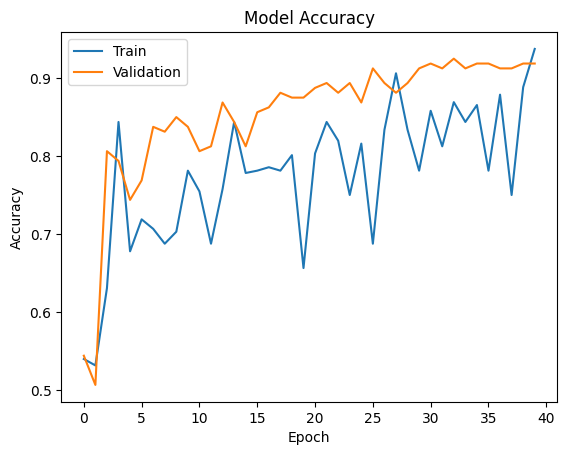

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()



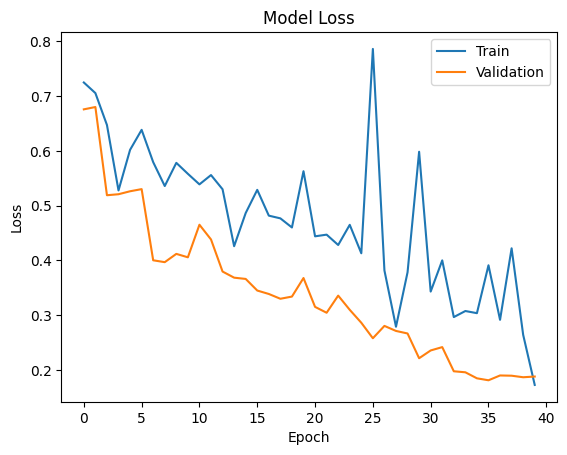

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [42]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - accuracy: 0.9187 - loss: 0.1879
Test Loss: 0.18791179358959198
Test Accuracy: 0.918749988079071


In [43]:
if not os.path.isdir('model'):
    os.mkdir('model')
model.save_weights('model/brain_tumor_model.weights.h5')

In [44]:
model.load_weights("model/brain_tumor_model.weights.h5")
cnn_val = model.evaluate(val_generator)
cnn_test = model.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 814ms/step - accuracy: 0.9244 - loss: 0.1768
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - accuracy: 0.9244 - loss: 0.1768


In [45]:
print("val_loss:", cnn_val[0])
print("val_accuracy:", cnn_val[1])
print("test_loss:", cnn_test[0])
print("test_accuracy:", cnn_test[1])

val_loss: 0.1768471598625183
val_accuracy: 0.9244186282157898
test_loss: 0.1768471598625183
test_accuracy: 0.9244186282157898


In [46]:
cnn_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(cnn_pred, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step


In [47]:
y_true = test_generator.classes

In [48]:
# Precision, Recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Precision: 0.8878
Recall: 0.9775
F1-score: 0.9305
Confusion Matrix:
[[72 11]
 [ 2 87]]


TN = 72 correctly predicted as No Tumor

FP = 11 incorrectly predicted as Tumor 

FN = 2 incorrectly predicted as No Tumor 

TP = 87 correctly predicted as Tumor

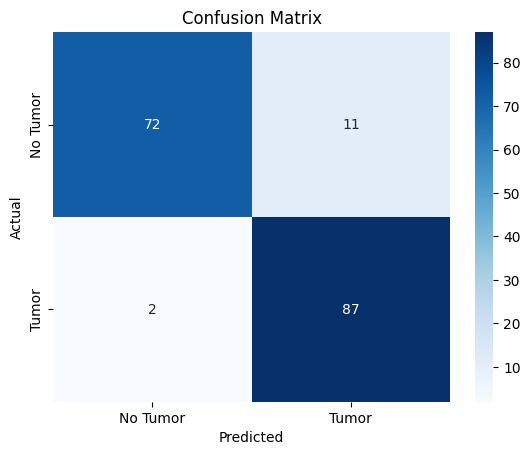

In [49]:
import seaborn as sns

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Tumor", "Tumor"], 
            yticklabels=["No Tumor", "Tumor"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [50]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [51]:
sample_batch = next(train_generator)
sample_images = sample_batch[0]
sample_labels = sample_batch[1]
# no run

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,038,664 (110.77 MB)

 Trainable params: 9,679,554 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,359,110 (73.85 MB)

In [53]:
feature_extractor = tf.keras.models.Model(
    inputs=model.layers[0].input,
    outputs=model.get_layer('dense_1').output
)

In [54]:
# Train features
train_features = feature_extractor.predict(train_generator, verbose=1)
train_flat = train_features.reshape(train_features.shape[0], -1)
y_train = train_generator.classes[:train_flat.shape[0]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 667ms/step


In [55]:
# Validation features
val_features = feature_extractor.predict(val_generator, verbose=1)
val_flat = val_features.reshape(val_features.shape[0], -1)
y_val = val_generator.classes[:val_flat.shape[0]]

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step


In [56]:

# Test features
test_features = feature_extractor.predict(test_generator, verbose=1)
test_flat = test_features.reshape(test_features.shape[0], -1)
y_test = test_generator.classes[:test_flat.shape[0]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step


In [57]:
print("Train feature shape:", train_flat.shape)
print("Val feature shape:", val_flat.shape)
print("Test feature shape:", test_flat.shape)

Train feature shape: (1385, 2)
Val feature shape: (172, 2)
Test feature shape: (172, 2)


## MODEL 2: VGG16

In [60]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout



In [61]:
vgg16_weight_path = ("../model/brain_tumor_model.weights.h5")
vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)  # Match your data
)


In [62]:
vgg.trainable = False

In [63]:

# create rge vgg16 model

vgg16 = Sequential([
    vgg,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Based on your output shape (32, 2)
])
vgg16.layers[0].trainable = False


In [64]:
vgg16.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

vgg16.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [65]:
sample_batch = next(train_generator)
print(f"Input shape: {sample_batch[0].shape}")
print(f"Output shape: {sample_batch[1].shape}")

# Also check your model's expected input
print(f"Model input shape: {vgg16.input_shape}")

Input shape: (32, 224, 224, 3)
Output shape: (32, 2)
Model input shape: (None, 224, 224, 3)


In [67]:
vgg16_history = vgg16.fit(
    train_generator,
    steps_per_epoch=43,
    epochs=40,
    validation_data=val_generator,
    validation_steps=30,
)




Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 534s 12s/step - accuracy: 0.5817 - loss: 0.6739 - val_accuracy: 0.5756 - val_loss: 0.6172
Epoch 2/40


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5000 - loss: 0.6643 - val_accuracy: 0.6105 - val_loss: 0.6117
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 545s 13s/step - accuracy: 0.6334 - loss: 0.6302 - val_accuracy: 0.7558 - val_loss: 0.5418
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8125 - loss: 0.5053 - val_accuracy: 0.7616 - val_loss: 0.5383
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 553s 13s/step - accuracy: 0.7021 - loss: 0.5823 - val_accuracy: 0.7849 - val_loss: 0.4890
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7812 - loss: 0.5387 - val_accuracy: 0.7907 - val_loss: 0.4885
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 522s 12s/step - accuracy: 0.7191 - loss: 0.5591 - val_accuracy: 0.8081 - val_loss: 0.4514
Epoch 8/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9062 - loss: 0.3897 - val_accuracy: 0.8081 - val_loss: 0.4484
Epoch 9/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 470s 11s/step - accuracy: 0.7147 - loss: 0.5450 - val_accuracy: 0.8256 - val_loss: 0.

In [68]:

predictions = vgg16.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate on generators (no need for separate y_val, y_test)
train_loss, train_acc = vgg16.evaluate(train_generator, verbose=0)
test_loss, test_acc = vgg16.evaluate(test_generator, verbose=0)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step
Train accuracy: 0.7964
Test accuracy: 0.8488


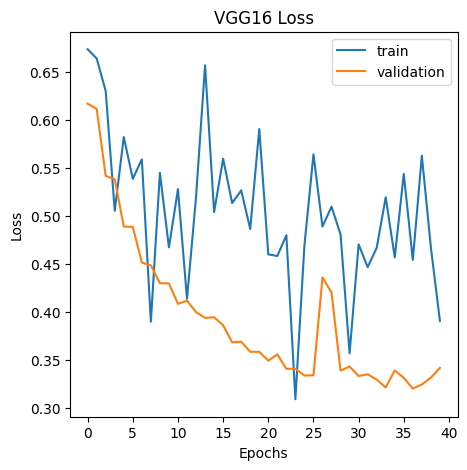

In [111]:

plt.figure(figsize=(5,5))
# plot loss during training
plt.subplot()
plt.title('VGG16 Loss')
plt.plot(vgg16_history.history['loss'], label='train')
plt.plot(vgg16_history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



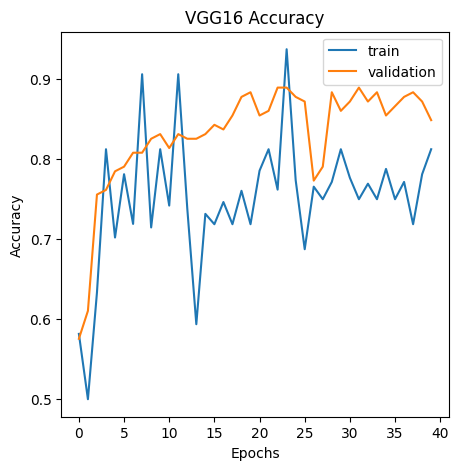

In [113]:
# plot accuracy during training
plt.figure(figsize=(5,5))
plt.subplot()
plt.title('VGG16 Accuracy')
plt.plot(vgg16_history.history['accuracy'], label='train')  # Changed from 'acc' to 'accuracy'
plt.plot(vgg16_history.history['val_accuracy'], label='validation')  # Changed from 'val_acc' to 'val_accuracy'
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [71]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.796, Test: 0.849


In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = test_generator.classes  # works if using ImageDataGenerator.flow_from_directory

accuracy = np.mean(predicted_classes == true_labels)
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
f1 = f1_score(true_labels, predicted_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8488
Precision: 0.7944
Recall: 0.9551
F1 Score: 0.8673


Confusion Matrix:
 [[61 22]
 [ 4 85]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.73      0.82        83
           1       0.79      0.96      0.87        89

    accuracy                           0.85       172
   macro avg       0.87      0.84      0.85       172
weighted avg       0.86      0.85      0.85       172



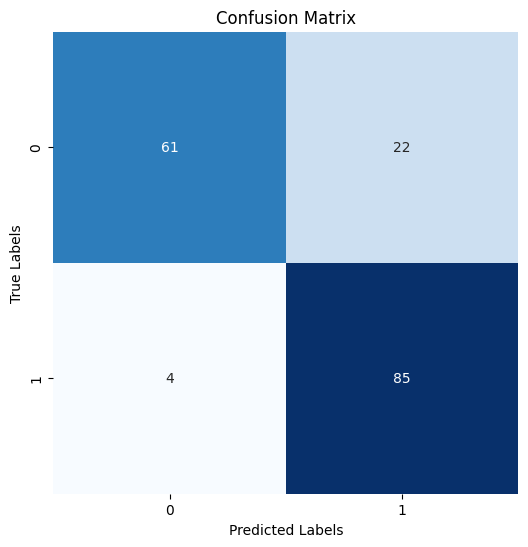

In [73]:
cm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:\n", cm)

# Optional: Classification report
print("\nClassification Report:\n", classification_report(true_labels, predicted_classes))

# 4. Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# MODEL 3: SVM 

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_val_scaled   = scaler.transform(val_features)
X_test_scaled  = scaler.transform(test_features)

In [75]:
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Train PCA shape:", X_train_pca.shape)

Train PCA shape: (1385, 1)


In [76]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.001, 0.01, 0.1, 1],
    "kernel": ["linear", "rbf"]
}

In [77]:
grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train_pca, y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.5s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=0.00

GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [78]:
svm_best = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [116]:
y_pred = svm_best.predict(X_test_pca)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[66 17]
 [ 2 87]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.87        83
           1       0.84      0.98      0.90        89

    accuracy                           0.89       172
   macro avg       0.90      0.89      0.89       172
weighted avg       0.90      0.89      0.89       172

Test Accuracy: 0.8895348837209303


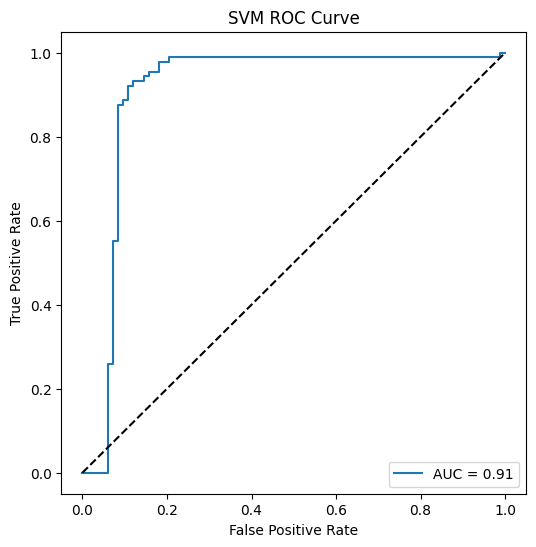

In [80]:

# ROC curve
from sklearn.metrics import roc_curve, auc

y_score = svm_best.decision_function(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend()
plt.show()

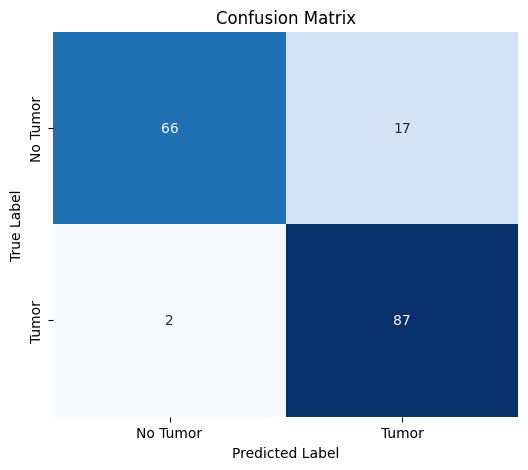

In [119]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Model: ANN 

In [93]:
ann_model = Sequential([
    vgg,
    Flatten(),  # turn CNN feature maps into 1D
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="softmax")  # categorical classification
])

In [95]:
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [96]:
ann = ann_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 503s 11s/step - accuracy: 0.6058 - loss: 1.7924 - val_accuracy: 0.7733 - val_loss: 0.4653
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 645s 15s/step - accuracy: 0.7350 - loss: 0.5976 - val_accuracy: 0.8430 - val_loss: 0.3753
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 580s 13s/step - accuracy: 0.7487 - loss: 0.5219 - val_accuracy: 0.8663 - val_loss: 0.3542
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 563s 12s/step - accuracy: 0.8101 - loss: 0.4107 - val_accuracy: 0.9128 - val_loss: 0.2494
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 553s 13s/step - accuracy: 0.8209 - loss: 0.4039 - val_accuracy: 0.9128 - val_loss: 0.2712
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 682s 16s/step - accuracy: 0.8505 - loss: 0.3427 - val_accuracy: 0.9360 - val_loss: 0.1758
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 522s 12s/step - accuracy: 0.8635 - loss: 0.3090 - val_accuracy: 0.9360 - val_loss: 0.2101
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 839s 19s/step - accuracy: 0.8599 - loss: 0.3183 - val_accuracy: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 60s 10s/step
Confusion Matrix:
 [[83  0]
 [25 64]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        83
           1       1.00      0.72      0.84        89

    accuracy                           0.85       172
   macro avg       0.88      0.86      0.85       172
weighted avg       0.89      0.85      0.85       172

Test Accuracy: 0.8546511627906976


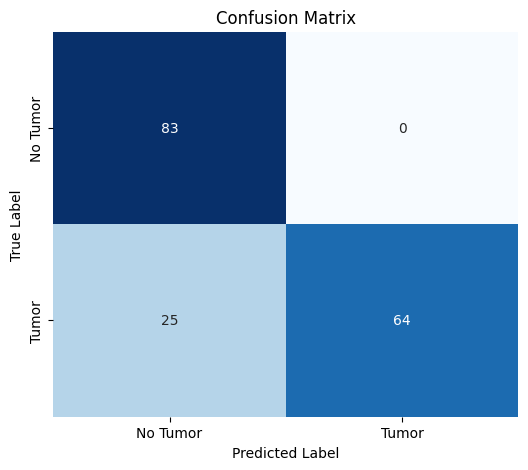

In [126]:

# Predict probabilities
y_prob = ann_model.predict(test_generator)

if y_prob.shape[1] == 1:  
    y_pred = (y_prob > 0.5).astype("int32").flatten()  
else:  
    y_pred = np.argmax(y_prob, axis=1)

y_true = test_generator.classes

# Confusion matrix & report
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Test Accuracy:", accuracy_score(y_true, y_pred))



cm_ann = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

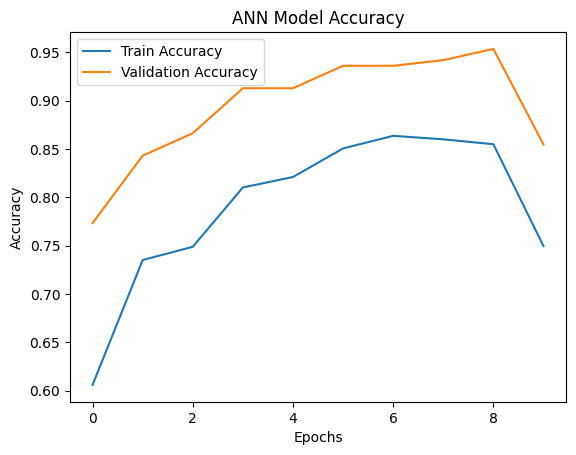

In [102]:
plt.subplot()
plt.plot(ann.history['accuracy'], label="Train Accuracy")
plt.plot(ann.history['val_accuracy'], label="Validation Accuracy")
plt.title("ANN Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()






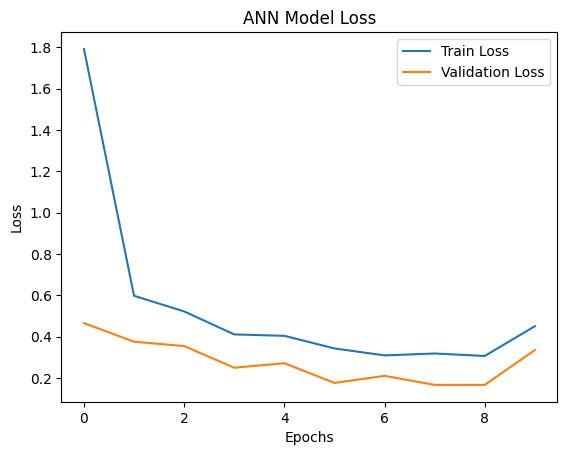

In [103]:
# Loss
plt.subplot()
plt.plot(ann.history['loss'], label="Train Loss")
plt.plot(ann.history['val_loss'], label="Validation Loss")
plt.title("ANN Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()